In [ ]:
#uncomment to clean your cache if needed
# !rm -rf ~/.cache/huggingface/datasets
# !rm -rf /root/.cache/huggingface/datasets
# !rm -rf /content/hf_cache
# !rm -rf /root/.cache/huggingface/modules/datasets_modules/datasets/social_bias_frames


In [1]:
# from google.colab import drive
# from google.colab import userdata
# userdata.get('HF_TOKEN')


In [2]:
# from huggingface_hub import login
# from google.colab import userdata

# # Retrieve token from Colab secrets
# hf_token = userdata.get('HF_TOKEN')

# # Authenticate with Hugging Face
# login(token=hf_token)


In [3]:
# from huggingface_hub import whoami

# user_info = whoami()
# print(f"✅ You are logged in as: {user_info['name']}")

In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
import torch


In [6]:
pd.set_option('display.max_rows', None)

## **DOWNLOADING -ONLY RUN ONCE **

In [ ]:
# Mapping from bias type to file path
# splits = {
#     'None': 'data/None-00000-of-00001.parquet',
#     'race': 'data/race-00000-of-00001.parquet',
#     'victim': 'data/victim-00000-of-00001.parquet',
#     'culture': 'data/culture-00000-of-00001.parquet',
#     'gender': 'data/gender-00000-of-00001.parquet',
#     'body': 'data/body-00000-of-00001.parquet',
#     'disabled': 'data/disabled-00000-of-00001.parquet',
#     'social': 'data/social-00000-of-00001.parquet'
# }

# # Hugging Face dataset base path
# base_path = "hf://datasets/Ayush-Singh/social-bias-frames-splits/"

# # Read and tag each split
# all_dfs = []
# for bias_type, path in splits.items():
#     print(f"Loading {bias_type}...")
#     df_split = pd.read_parquet(base_path + path)
#     df_split["bias_type"] = bias_type  # Tag with source
#     all_dfs.append(df_split)

# # Concatenate into one DataFrame
# df_all = pd.concat(all_dfs, ignore_index=True)

# # Optional: Show summary
# print("✅ Combined dataset shape:", df_all.shape)
# print("🔍 Examples per bias type:\n", df_all["bias_type"].value_counts())

In [ ]:
#df_all.head(3)

In [ ]:
#df_all['targetMinority'].value_counts()

In [ ]:
#df_all.nunique()

In [ ]:
#df_all['targetStereotype'].value_counts()

In [ ]:
#df_all.isna().sum()

### MOUNT THE DRIVE BEFORE RUNNING ANYTHING ELSE if you are using Drive

In [ ]:
# path = "/content/drive/MyDrive/capstone_2025/reddit_bias_models/"
# drive.mount("/content/drive")

Mounted at /content/drive


## SAVE **ONLY** ONCE ON DIST

In [4]:

# os.makedirs(path, exist_ok=True)  # <== create the folder safely

# df_all.to_csv(path + "social_bias.csv", index=False)
# print(f"CSV saved to: {path}social_bias.csv")

## LOADING THE SOCIAL-BIAS-FRAMES DATASET

In [7]:
# Assuming you've already loaded your DataFrame
df = pd.read_csv('social_bias.csv')

In [ ]:
df.columns

Index(['whoTarget', 'intentYN', 'sexYN', 'sexReason', 'offensiveYN',
       'annotatorGender', 'annotatorMinority', 'sexPhrase',
       'speakerMinorityYN', 'WorkerId', 'HITId', 'annotatorPolitics',
       'annotatorRace', 'annotatorAge', 'post', 'targetMinority',
       'targetCategory', 'targetStereotype', 'dataSource', 'bias_type'],
      dtype='object')

In [9]:
df.columns[df.isna().any()].tolist()

['whoTarget',
 'sexReason',
 'offensiveYN',
 'annotatorMinority',
 'sexPhrase',
 'speakerMinorityYN',
 'targetMinority',
 'targetCategory',
 'targetStereotype',
 'bias_type']

In [10]:
print(df['bias_type'].value_counts(dropna=False))  # count with NaNs


bias_type
NaN         23484
race         3883
gender       3535
culture      2472
victim       2028
disabled      753
social        642
body          441
Name: count, dtype: int64


In [11]:
df['bias_type'].fillna('Neutral', inplace=True)

/var/folders/0x/xqxsgny17f3dqfdj_9kbz2wh0000gn/T/ipykernel_26237/4041162039.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bias_type'].fillna('Neutral', inplace=True)


In [12]:
print(df['bias_type'].value_counts(dropna=False))

bias_type
Neutral     23484
race         3883
gender       3535
culture      2472
victim       2028
disabled      753
social        642
body          441
Name: count, dtype: int64


## TRAIN VAL TEST SPLITS

In [ ]:
# Set a seed for reproducibility
RANDOM_SEED = 42

# Step 1: First split into train (80%) and temp (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, stratify=df['bias_type'])

# Step 2: Split temp into validation (10%) and test (10%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_SEED, stratify=temp_df['bias_type'])

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 29790
Validation size: 3724
Test size: 3724


## BASE LINE WITH roberta-hate-speech-dynabench

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")

In [ ]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
majority_df = df[df['bias_type']=='Neutral'].sample(10, random_state=42)

In [ ]:
minority_df = df[df['bias_type']!='Neutral'].sample(20, random_state=42)

In [ ]:
downsample_df = pd.concat([majority_df, minority_df],axis=0)

In [ ]:
downsample_df['bias_type'].value_counts()

,count
bias_type,
Neutral,10
victim,5
race,4
gender,4
social,3
culture,2
disabled,2


In [ ]:
texts = downsample_df['post'].tolist()
cat=downsample_df['bias_type'].tolist()

In [ ]:
# Tokenize
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
predicted_labels = []
# Predict
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).tolist()
    probs = F.softmax(logits, dim=1)
    confidence_scores = probs.max(dim=1).values.tolist()



# Convert to readable labels if available
# print("Predictions:")
for text, pred in zip(texts, predictions):
    pred_label = "Biased" if pred== 1 else "Not Biased"
    predicted_labels.append(pred_label)
    # print(f"Text: {text[:120]}...\nPrediction: {pred.item()}\n---")

In [ ]:
result_roberta = pd.DataFrame({'text': texts, 'category': cat, 'predicted_Roberta': predicted_labels, 'confidence_Roberta':confidence_scores})

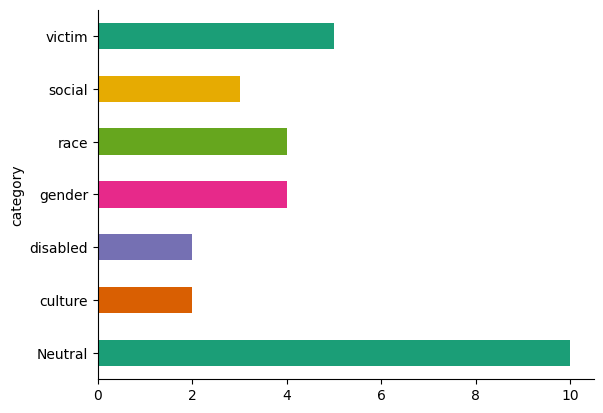

In [ ]:
result_roberta.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## BASE LINE WITH hateBERT-hatexplain

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")
model = AutoModelForSequenceClassification.from_pretrained("GroNLP/hateBERT", num_labels=2)
model.eval()

In [ ]:
inputs_hate = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

In [ ]:
with torch.no_grad():
    outputs = model(**inputs_hate)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).tolist()
    probs = torch.softmax(logits, dim=1)[:, 1].tolist()

In [ ]:
predict_label = []

In [ ]:
for text, pred in zip(texts, preds):
    pred_label = "abusive/hateful" if pred == 1 else "Neutral"
    predict_label.append(pred_label)
    #print(f"Text: {text[:120]}...\nPrediction: {pred}\n---")

In [ ]:
result_hateBERT = pd.DataFrame({'text': texts, 'category': cat, 'predicted_hateBert': predict_label, "confidence_hateBert": probs})

In [ ]:
# result_hateBERT

In [ ]:
compare_models = pd.merge(
    result_hateBERT,
    result_roberta,
    on=['text', 'category'],
    how='inner'  # use 'outer' if you want to keep all posts even if one model didn't predict
)

In [ ]:
compare_models = compare_models.rename(columns={'category': 'actual'})

In [ ]:
# compare_models

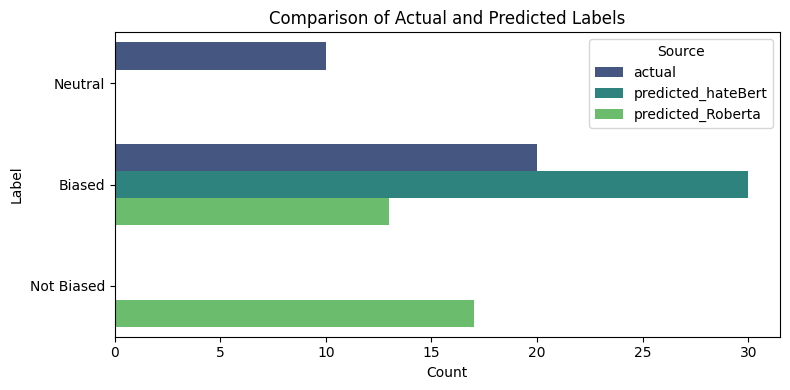

In [ ]:
# Melt the DataFrame to have a single column for labels and a column for the source
melted_df = compare_models.melt(
    id_vars=['text'],
    value_vars=['actual', 'predicted_hateBert', 'predicted_Roberta'],
    var_name='Label Source',
    value_name='Label'
)

#Change the label to 'Neutral' if the label source is 'category' and the label is 'None'
melted_df.loc[(melted_df['Label Source'] == 'actual') & (melted_df['Label'] == 'Neutral'), 'Label'] = 'Neutral'
melted_df.loc[(melted_df['Label Source']== 'actual')  & (melted_df['Label'] != 'Neutral'), 'Label'] = 'Biased'
melted_df.loc[(melted_df['Label Source']== 'predicted_hateBert') & (melted_df['Label'] == 'abusive/hateful'), 'Label'] = 'Biased'

#Plot the distribution of labels
plt.figure(figsize=(8, 4))
sns.countplot(data=melted_df, y='Label', hue='Label Source', palette='viridis')
plt.title('Comparison of Actual and Predicted Labels')
plt.xlabel('Count')
plt.ylabel('Label')
plt.legend(title='Source')
plt.tight_layout()
plt.show()